In [1]:
#!pip install seaborn

In [2]:
#import necessary libraries
import pandas as pd
import nltk
import seaborn as sns
import sys # needed this for certain print options during debugging
import numpy as np #lmao why did we not have this before
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import json # since we have a json file this time as our dataset.
from IPython.display import display, HTML
import time
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soumyankar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
steam_2022 = pd.read_json('data/steam_games.json')
steam_2022 = steam_2022.T.reset_index()
steam_2022.drop("index", axis=1, inplace=True)
steam_cols=steam_2022.columns.to_list()

In [4]:
# wilson score for finding ratings from positive and negative votes
from math import sqrt
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
#     return (lower_bound, upper_bound)
    return ((lower_bound + upper_bound)/2)

In [5]:
# Converting tags dictionary to list only, and getting rid of those numbers - whatever thhey mean.
# changing total_votes column as well
# and the average rating
genres = []
for index,row in steam_2022.iterrows():
#     current_row_tags = list(map(str.lower, row['tags'].keys()))
    current_row_genres = list(map(str.lower, row['genre'].split(',')))
#     current_row_categories = list(map(str.lower, row['categories']))
#     new_kws = list(set(current_row_tags + current_row_genres + current_row_categories))
    new_kws = list(set(current_row_genres))
    genres.append(new_kws)
#     new_kws = " ".join(new_kws)
#     steam_2022.loc[index, 'keywords'] = new_kws
    current_row_total_votes = row['positive'] + row['negative']
    steam_2022.loc[index, 'total_votes'] = current_row_total_votes
    positive_votes = row['positive']
    if (current_row_total_votes != 0) & (positive_votes != 0):
        current_row_rating = wilson((positive_votes/current_row_total_votes), current_row_total_votes)
        steam_2022.loc[index, 'rating'] = round(current_row_rating*100,2)
    
steam_2022['keywords'] = genres
display(steam_2022.sample(1))

,appid,name,short_description,developer,publisher,genre,tags,type,categories,owners,positive,negative,price,initialprice,discount,ccu,languages,platforms,release_date,required_age,website,header_image,total_votes,rating,keywords
29977,296010,NeonXSZ,"Prepare to destroy, loot, and pilot remarkably agile cyber gunships in an open world where every opponent has unique intelligence and skill. Combine hundreds of upgrades with action RPG loot and leveling for a gaming experience quite unlike anything you have played before.",Intravenous Software,None - Independent,"Action, Indie, RPG","{'FPS': 112, '6DOF': 107, 'Sandbox': 102, 'Open World': 99, 'Action': 96, 'RPG': 90, 'Sci-fi': 89, 'Procedural Generation': 86, 'Loot': 82, 'Action RPG': 80, 'Shooter': 76, 'Cyberpunk': 68, 'Combat': 67, 'Arena Shooter': 63, 'Indie': 56, 'Rogue-lite': 51, 'First-Person': 42, 'Funny': 35, 'Singleplayer': 34, 'Difficult': 32}",game,"[Single-player, Partial Controller Support]","0 .. 20,000",83,20,999,999,0,0,English,"{'windows': True, 'mac': True, 'linux': True}",2016/02/22,0,http://www.neonxsz.com,https://cdn.akamai.steamstatic.com/steam/apps/296010/header.jpg?t=1572553020,103.0,79.48,"[action, indie, rpg]"


In [6]:
df = steam_2022[['appid', 'name','short_description','rating','keywords']].copy()
print("Creating new DataFrame with necessary columns")
print("---------------------------------------------")
df.sample(2)

Creating new DataFrame with necessary columns
---------------------------------------------


,appid,name,short_description,rating,keywords
40170,574420,Dr. Doyle & The Mystery Of The Cloche Hat,"A point &amp; click mystery adventure game set in 1920s Southeast England. Assume the role of Dr. Doyle, gather clues, interrogate witnesses, make assumptions, reach conclusions, decide the guilty party and solve the mystery of the cloche hat.",81.56,"[ indie, adventure]"
20911,1718160,Crimzon Clover World EXplosion,"Prepare yourself for an insatiable rain of bullets, bombs, and beams in Crimzon Clover. Earn all the power-ups for an overpowered experience in the all new ARRANGE version.",96.18,"[action, indie]"


In [7]:
# removing any games that have keywords at all
prev_count = len(df.index)
df = df[df.keywords.notnull()]
new_count = len(df.index)
print("Removing all rows that do not have any keywords")
print("-----------------------------------------------")
print("Original Row Count = ", prev_count)
print("New Row Count = ", new_count)
print("Rows Removed = ",(prev_count - new_count))

Removing all rows that do not have any keywords
-----------------------------------------------
Original Row Count =  55691
New Row Count =  55691
Rows Removed =  0


Frequency distribution for genres
---------------------------------


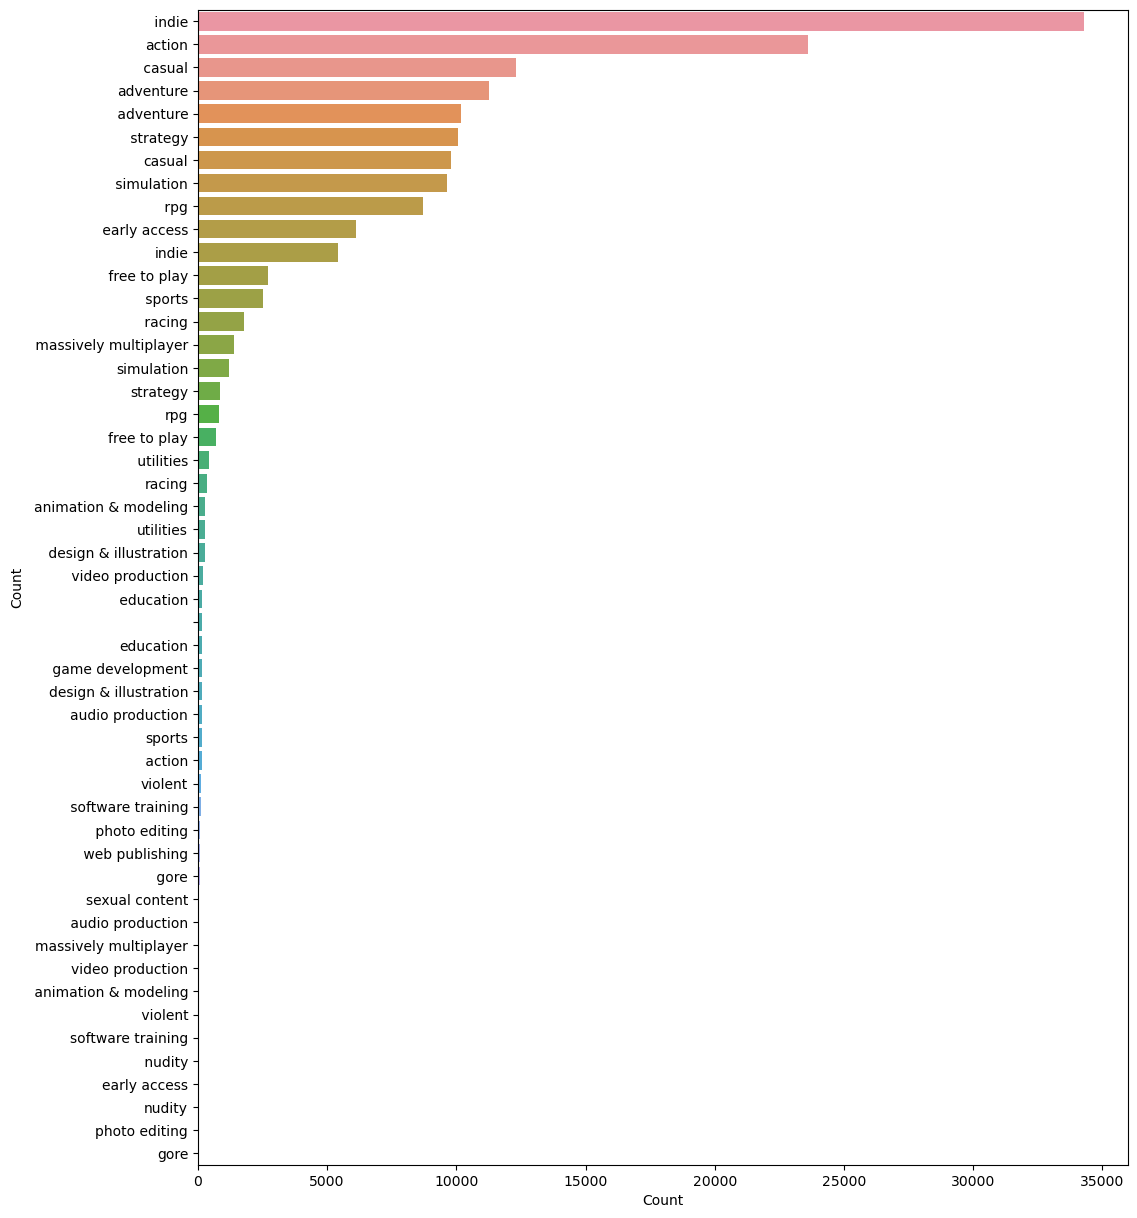

--- 64.29190492630005 seconds ---


In [8]:
# Lets try to do this to understand the dataset a little better.
print("Frequency distribution for genres")
print("---------------------------------")
# get all genre tags in a list
start_time = time.time()
all_genres = sum(genres,[])
len(set(all_genres))
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

print("--- %s seconds ---" % (time.time() - start_time) )

In [9]:
# Normalistic text cleaning
# function for text cleaning 
import re
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

df['clean_description'] = df['short_description'].apply(lambda x: clean_text(x))

Printing most frequent words


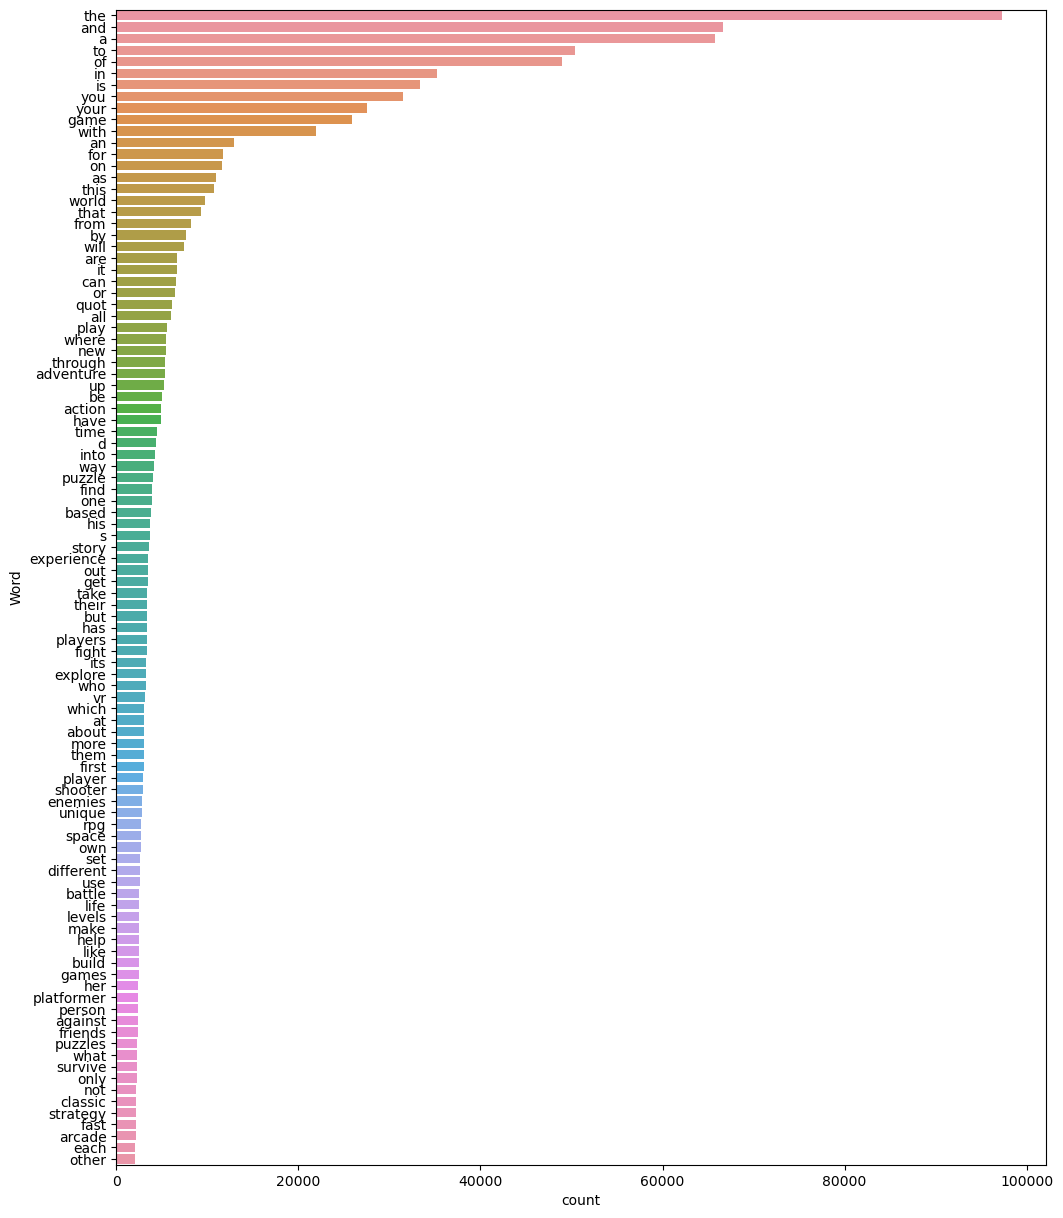

--- 3.503009080886841 seconds ---


In [10]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
print("Printing most frequent words")
start_time = time.time()
freq_words(df['clean_description'], 100)
print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
# In case you dont have this
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soumyankar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Printing top 100 words over the entire dataset
----------------------------------------------


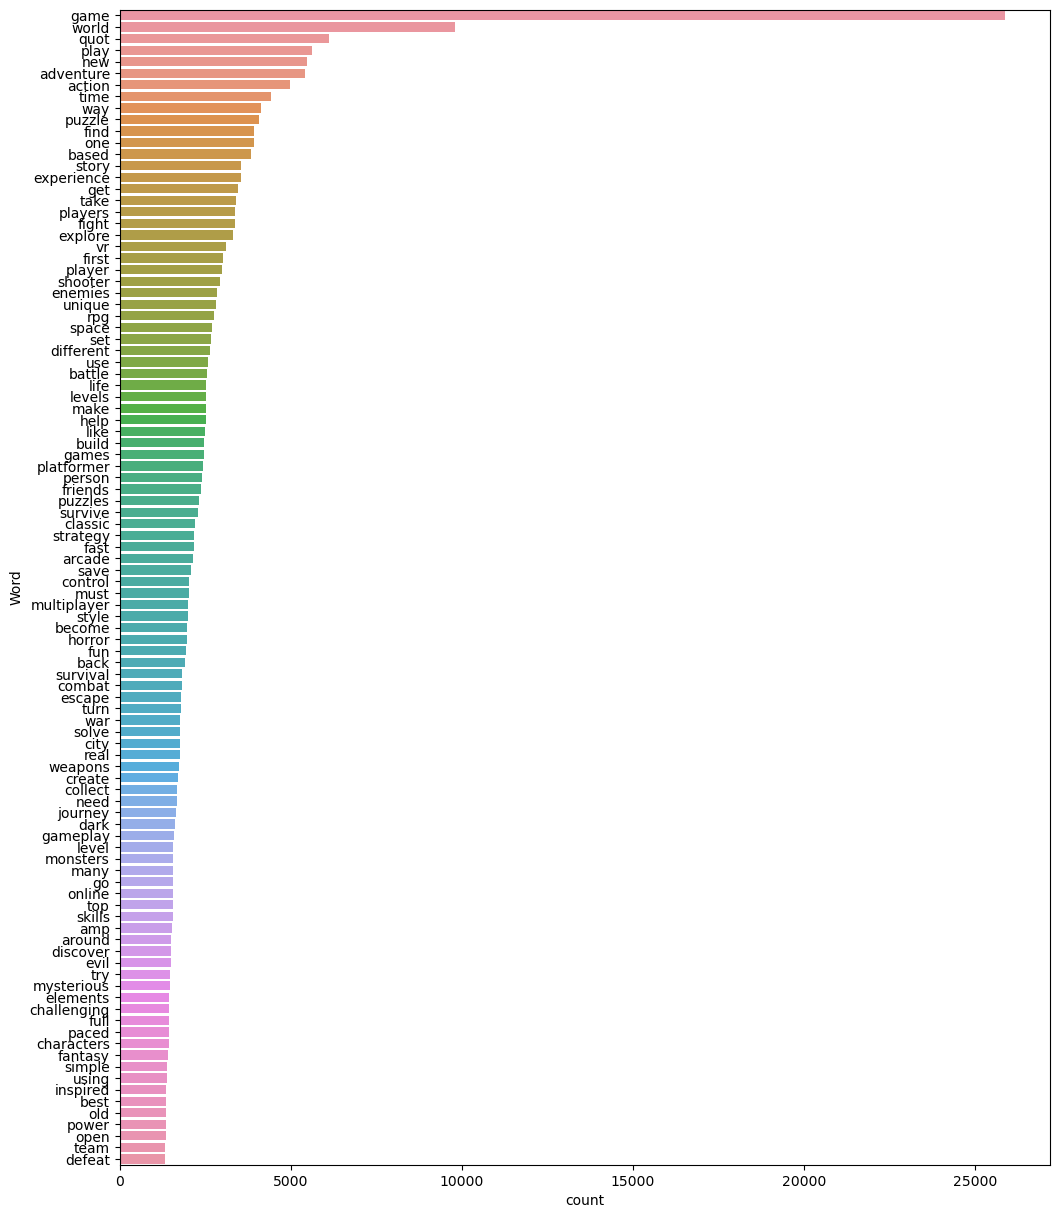

--- 3.112936019897461 seconds---


In [12]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print("Printing top 100 words over the entire dataset")
print("----------------------------------------------")
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

start_time = time.time()
df['clean_description'] = df['clean_description'].apply(lambda x: remove_stopwords(x))
freq_words(df['clean_description'], 100)
print("--- %s seconds---" % (time.time()-start_time))

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['keywords'])

# transform target variable
y = multilabel_binarizer.transform(df['keywords'])

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [15]:
# split dataset into training and validation set
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(df['clean_description'], y, test_size=0.2, random_state=9)

In [16]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [17]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [18]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [19]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/Users/soumyankar/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/soumyankar/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

OneVsRestClassifier(estimator=LogisticRegression())

In [20]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [22]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.5093813025852059

In [23]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [25]:
# Lets try to take 5 random games and see how well we are able to predict.
print("5 random predicitions from the dataset")
print("--------------------------------------")
start_time = time.time()
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Game: ", df['name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",df['keywords'][k], "\n")
    
print()

Game:  Seraph's Last Stand 
Predicted genre:  [(' indie', 'action')]
Actual genre:  ['action', ' casual'] 

Game:  Fighting Moore 
Predicted genre:  [(' indie', 'action')]
Actual genre:  [' adventure', 'action', ' strategy', ' rpg'] 

Game:  Happy Critters 
Predicted genre:  [('casual',)]
Actual genre:  ['casual'] 

Game:  Shahrzad - The Storyteller 
Predicted genre:  [(' casual', ' indie')]
Actual genre:  ['casual'] 

Game:  Retimed 
Predicted genre:  [(' indie', 'action')]
Actual genre:  ['action', ' indie', ' casual'] 

